In [1]:
import numpy as np
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from lib.shrinkage_estimators import shrinkage

import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
%matplotlib inline

In [2]:
n = 250
P = np.loadtxt(f"../output/data/Patchy_V6C_BOSS_DR12_NGC_z1_power_spectrum_processed_{n}.matrix")
cov_nercome = np.loadtxt(f"../output/data/Patchy_V6C_BOSS_DR12_NGC_z1_cov_nercome_{n}.matrix")
cov_sample = np.loadtxt(f"../output/data/Patchy_V6C_BOSS_DR12_NGC_z1_cov_sample_{n}.matrix")

# 'Real' covariance matrix before processing.
# The term 'real' here indicates that this is the matrix that we use to compare
# our estimates to.
cov_real_preproc = np.loadtxt("../data/C_2048_BOSS_DR12_NGC_z1_V6C_1_1_1_1_1_10_200_200_prerecon.matrix")
indices = np.concatenate((np.arange(40), np.arange(40)+80, np.arange(40)+160))
cov_real = (cov_real_preproc[indices, :])[:, indices]

In [12]:
#cov_shrinkage, S, lmbda_est = shrinkage.shrinkage_cov_matrix(P, cov_nercome)
#print(lmbda_est)

lmbda_guess = 0.3
cov_shrinkage = (1-lmbda_guess)*cov_sample + lmbda_guess*cov_nercome

In [13]:
evals_nercome = np.linalg.eigvalsh(cov_nercome)
evals_shrinkage = np.linalg.eigvalsh(cov_shrinkage)
evals_sample = np.linalg.eigvalsh(cov_sample)
evals_real = np.linalg.eigvalsh(cov_real)

Text(0, 0.5, 'Eigenvalues')

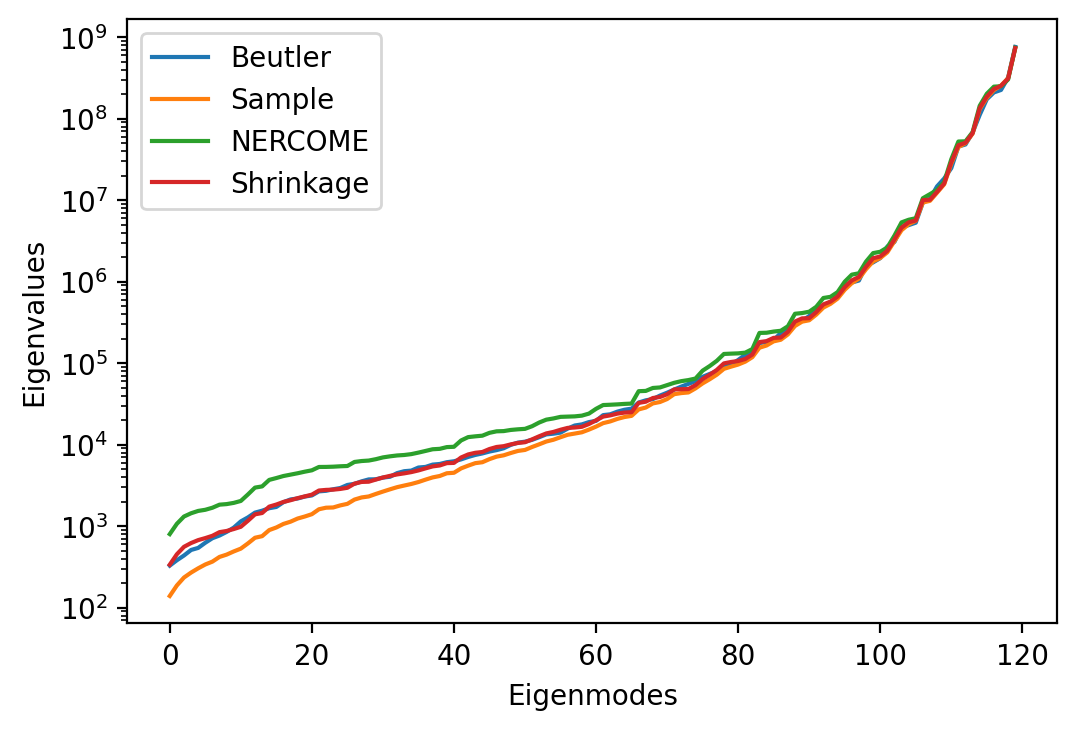

In [14]:
plt.figure(dpi=200)
plt.plot(evals_real, label="Beutler")
plt.plot(evals_sample, label="Sample")
plt.plot(evals_nercome, label="NERCOME")
plt.plot(evals_shrinkage, label="Shrinkage")
plt.yscale("log")
plt.legend()
plt.xlabel("Eigenmodes")
plt.ylabel("Eigenvalues")